In [1]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem, ChemicalFeatures, Draw
from rdkit.Chem import rdMolAlign
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG=True

import nglview as nv

In [2]:
def generate_conformers(molecule, n_conformers, random_seed=-1, alignment=False):
    """Generate n conformers for a molecule"""
    molecule = Chem.AddHs(molecule) # Add hydrogens to generate realistic geometries
    cids = AllChem.EmbedMultipleConfs(molecule, numConfs=n_conformers, randomSeed=random_seed)
    
    if alignment:
        AllChem.AlignMolConformers(molecule)
    return molecule

def view_ligands(molecules):
    """Generate a view of the ligand molecules.

    Parameters
    -----------
    molecules: an rdkit.Chem.rdchem.Mol or a list of rdkit.Chem.rdchem.Mol

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    if not isinstance(molecules, list):
        molecules = [molecules]
    
    view = nv.NGLWidget()
    for molecule in molecules:
        component = view.add_component(molecule)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view


def view_pharmacophore(pharmacophore, molecules, show_ligands=True):
    
    feature_colors = {
    "Acceptor": (0.90, 0.30, 0.24),  # Red
    "Aromatic": (1, 0.9, 0),  # Yellow
    "Donor": (0.13, 0.56, 0.30), # Green
    "Hydrophobic": (1, 0.9, 0),  # Yellow,
    "PosIonizable": (0.12, 0.36, 0.52), # Blue
    "NegIonizable": (0.90, 0.30, 0.24),  # Red
    }

    if show_ligands:
        view = view_ligands(molecules)
    else:
        view = nv.NGLWidget()
    
    sphere_radius = 1
    
    for featname, points in pharmacophore.items():
        for i, coords in enumerate(points):
            feature_color = feature_colors[featname]
            label = f"{featname}_{i}"
            view.shape.add_sphere(coords, feature_color, sphere_radius, label)
    
    return view


In [3]:
def feature_centroid(molecule, atom_indxs, conformer_idx):
    """
       Get the 3D coordinates of the centroid of a feature that encompasses
       more than one atom. This could be aromatic, hydrophobic, negative and positive features
    """
    
    n_atoms = len(atom_indxs)
    coords = np.zeros((n_atoms, 3))
    for j, idx in enumerate(atom_indxs):
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(idx)
            coords[j, 0] = position.x
            coords[j, 1] = position.y
            coords[j, 2] = position.z
    
    centroid = coords.mean(axis=0)
   
    return centroid

def get_feature_clusters(feat_coords, eps, min_samples):
    
    clusters = {}
    for feat, coords in feat_coords.items():
        db_scan = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
        
        labels = db_scan.labels_
        core_samples_mask = np.zeros_like(labels, dtype=bool)
        core_samples_mask[db_scan.core_sample_indices_] = True
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # print(f'Estimated number of clusters: {n_clusters} for {feat} feature' )
        # print(f'Estimated number of noise points: {n_noise}\n')
        
        centroids = []
        unique_labels = set(labels)
        for k in unique_labels:
            if k == -1:
                continue
            class_member_mask = (labels == k)
            cluster = feat_coords[feat][class_member_mask & core_samples_mask]
            cluster_centroid = cluster.mean(axis=0)
            centroids.append(cluster_centroid.tolist())
        
        clusters[feat] = centroids
    
    return clusters
    

def ligand_based_pharmacophore(ligands, eps=2, min_samples=0.75, feat_list=None):
    
    
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    
    if not feat_list:
        feat_list = ['Acceptor', 'Aromatic', 'Donor', 'Hydrophobe', 'PosIonizable', 'NegIonizable']
    
    feat_coords = {}
        
    for feature in feat_list:
        feat_coords[feature] = []
        
        for ligand in ligands:
           
            feats = factory.GetFeaturesForMol(ligand, includeOnly=feature)
            n_conformers = ligand.GetNumConformers()
            if n_conformers == 0: 
                n_conformers == 1
                
            for f in feats:

                atom_idxs = f.GetAtomIds()
                
                for conformer in range(n_conformers):
                
                    if len(atom_idxs) > 1: # Get the centroid of that feature
                        coords = feature_centroid(ligand, atom_idxs, conformer)
                    else:
                        position = ligand.GetConformer(conformer).GetAtomPosition(atom_idxs[0])
                        coords = np.zeros((3,))
                        coords[0] = position.x
                        coords[1] = position.y
                        coords[2] = position.z

                    feat_coords[feature].append(coords.tolist())
            
        feat_coords[feature] = np.array(feat_coords[feature])
        
    min_samples = int(min_samples * len(ligands)) 
    feature_clusters = get_feature_clusters(feat_coords, eps=eps, min_samples=min_samples)

    return feature_clusters
    

In [4]:
def get_ligand_features(ligand, feat_list=None):

    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    
    feats = factory.GetFeaturesForMol(ligand)
    
    feat_coords = {}
    
    if not feat_list:
        feat_list = ['Acceptor', 'Aromatic', 'Donor', 'Hydrophobe', 'PosIonizable', 'NegIonizable']
    
    for f in feats:
        
        feat_name = f.GetFamily()
        if feat_name not in feat_list:
            continue
        atom_idxs = f.GetAtomIds()
        
        try: 
            feat_coords[feat_name]
        except KeyError:
            feat_coords[feat_name] = []
            
        if len(atom_idxs) > 1: # Get the centroid of that feature
            coords = feature_centroid(ligand, atom_idxs, conformer_idx=0)
        else:
            position = ligand.GetConformer(0).GetAtomPosition(atom_idxs[0])
            coords = np.zeros((3,))
            coords[0] = position.x
            coords[1] = position.y
            coords[2] = position.z

        feat_coords[feat_name].append(coords.tolist())
    
    return feat_coords

5 molecules


RDKit WARNING: [15:26:50] WARNING: no name column found on line 0
RDKit WARNING: [15:26:50] WARNING: no name column found on line 1
RDKit WARNING: [15:26:50] WARNING: no name column found on line 2
RDKit WARNING: [15:26:50] WARNING: no name column found on line 3
RDKit WARNING: [15:26:50] WARNING: no name column found on line 4


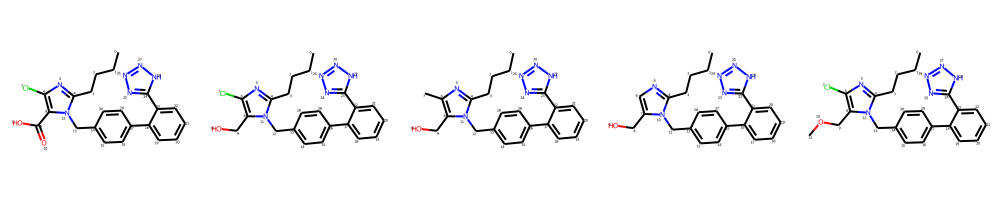

In [5]:
# Load inhibitors from smi file 
molecules = Chem.SmilesMolSupplier('../data/molecules.smi',delimiter='\t',titleLine=False)
print(f"{len(molecules)} molecules")
# Visualize molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=5, returnPNG=False)
# img.save("./mols.png")
img

In [6]:
# Generate conformers
molecules_1 = [generate_conformers(mol, 1, random_seed=1) for mol in molecules]

RDKit WARNING: [15:26:50] WARNING: no name column found on line 0
RDKit WARNING: [15:26:50] WARNING: no name column found on line 1
RDKit WARNING: [15:26:50] WARNING: no name column found on line 2
RDKit WARNING: [15:26:50] WARNING: no name column found on line 3
RDKit WARNING: [15:26:50] WARNING: no name column found on line 4


In [7]:
view = view_ligands(molecules_1)
view

NGLWidget()

## Inspect each Ligand

In [8]:
ligand = molecules_1[0]
ligand_feats = get_ligand_features(ligand, feat_list=["Acceptor", "Aromatic"])
view = view_pharmacophore(ligand_feats, ligand, show_ligands=True)
view

NGLWidget()

In [9]:
ligand = molecules_1[1]
ligand_feats = get_ligand_features(ligand, feat_list=["Acceptor", "Aromatic"])
view = view_pharmacophore(ligand_feats, ligand, show_ligands=True)
view

NGLWidget()

In [10]:
ligand = molecules_1[2]
ligand_feats = get_ligand_features(ligand, feat_list=["Acceptor", "Aromatic"])
view = view_pharmacophore(ligand_feats, ligand, show_ligands=True)
view

NGLWidget()

## Generate and visualize pharmacophore

In [11]:
pharmacophore_1 = ligand_based_pharmacophore(molecules_1, feat_list=["Aromatic", "Acceptor"])
pharmacophore_1

{'Aromatic': [[4.772120382103004, 1.6938234021498308, -1.314983446435873],
  [1.1554928629311463, 0.2486733734788809, 0.2894131687571237],
  [5.059542367949372, -0.3623565250039384, 1.2255964226287321],
  [-2.526508708037407, -1.8817953538544452, 0.37022356555445757]],
 'Acceptor': [[3.5298916917190364, 2.6710045219983765, -0.28065066090626917],
  [6.088629742139698, 0.95088297390595, -2.8521763037034322],
  [-3.095891051265329, -2.5894358774013866, -0.3413196031345316],
  [3.823119946366577, -1.6591914767359415, 1.853844753038291],
  [2.0400757194493893, 3.8736908376671355, 2.487228234145404],
  [2.563982994050958, -0.8943303764839435, -3.214026667163181]]}

In [12]:
view = view_pharmacophore(pharmacophore_1, molecules_1, show_ligands=True)
view

NGLWidget()

## Pharmacophore with multiple conformers

In [13]:
molecules_2 = [generate_conformers(molecule, 100, random_seed=1) for molecule in molecules]

RDKit WARNING: [15:26:52] WARNING: no name column found on line 0
RDKit WARNING: [15:26:58] WARNING: no name column found on line 1
RDKit WARNING: [15:27:02] WARNING: no name column found on line 2
RDKit WARNING: [15:27:07] WARNING: no name column found on line 3
RDKit WARNING: [15:27:13] WARNING: no name column found on line 4


In [14]:
pharmacophore_2 = ligand_based_pharmacophore(molecules_2, feat_list=["Aromatic", "Acceptor"])
pharmacophore_2

{'Aromatic': [[-0.09475914113239023,
   -0.01975468739702392,
   -0.004616666286079597]],
 'Acceptor': [[-0.0864778372572768,
   -0.19790577233115353,
   -0.0955264687043126]]}

In [15]:
view = view_pharmacophore(pharmacophore_2, molecules_2, show_ligands=True)
view

NGLWidget()

## Visualize and align conformers

In [16]:
def view_conformers(molecule):
    """
    Generate a view of the conformers of a molecule.

    Parameters
    -----------
    molecule: an rdkit.Chem.rdchem.Mol

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    view = nv.NGLWidget()
    for conformer in range(molecule.GetNumConformers()):
        mol_string = Chem.MolToMolBlock(molecule, confId=conformer)
        temp_mol = Chem.MolFromMolBlock(mol_string, removeHs=False)
        component = view.add_component(temp_mol)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

RDKit WARNING: [15:27:18] WARNING: no name column found on line 0


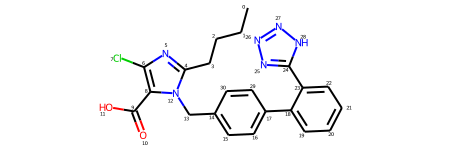

In [17]:
single_molecule = molecules[0]
single_molecule

In [18]:
single_molecule = generate_conformers(single_molecule, 10, random_seed=1)
single_molecule.GetNumConformers()

10

In [19]:
# Visualize conformers without alignment
view = view_conformers(single_molecule)
view

NGLWidget()

In [20]:
# generate conformers and align them
single_molecule = generate_conformers(single_molecule, 10, random_seed=1, alignment=True)
view = view_conformers(single_molecule)
view

NGLWidget()

## Align the other ligands

In [21]:
from rdkit.Chem import rdMolDescriptors
import copy

p = AllChem.ETKDGv2()

molecules_3 = copy.deepcopy(molecules_1)
molecules_3 = [generate_conformers(mol, 100) for mol in molecules_3]

crippen_contribs = [rdMolDescriptors._CalcCrippenContribs(mol) for mol in molecules_3]
crippen_ref_contrib = crippen_contribs[0]
# crippen_prob_contribs = crippen_contribs[1:]
crippen_prob_contribs = crippen_contribs

ref_mol = molecules_3[0]
# probe_mols = molecules_3[1:]
probe_mols = molecules_3

In [22]:
ref_mol.GetNumConformers()

100

In [23]:
view = nv.NGLWidget()
# component = view.add_component(ref_mol)
# component.clear()
# component.add_ball_and_stick(multipleBond=True)

crippen_score = []
aligned_molecules = []
for idx, mol in enumerate(probe_mols):
    tempscore = []
    
    for cid in range(100):
        crippenO3A = rdMolAlign.GetCrippenO3A(mol, ref_mol, crippen_prob_contribs[idx], crippen_ref_contrib, cid, 0)
        crippenO3A.Align()
        tempscore.append(crippenO3A.Score())
        
    best = np.argmax(tempscore)
    mol_string = Chem.MolToMolBlock(mol, confId=int(best))
    temp_mol = Chem.MolFromMolBlock(mol_string, removeHs=False)
    
    component = view.add_component(temp_mol)
    component.clear()
    component.add_ball_and_stick(multipleBond=True)
    
    crippen_score.append(tempscore[best])
    aligned_molecules.append(temp_mol)

view

NGLWidget()

In [24]:
crippen_score

[199.7038,
 177.48709150855262,
 162.9811254401298,
 179.55282018257736,
 173.54674935062937]

In [25]:
for mol in aligned_molecules:
    print(f"Number of conformers: {mol.GetNumConformers()}")

Number of conformers: 1
Number of conformers: 1
Number of conformers: 1
Number of conformers: 1
Number of conformers: 1


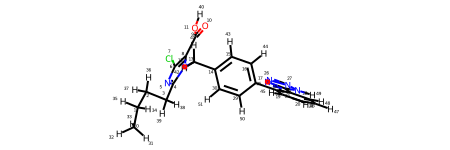

In [26]:
aligned_molecules[0]

In [27]:
pharmacophore_3 = ligand_based_pharmacophore(aligned_molecules, feat_list=["Aromatic", "Acceptor"])
pharmacophore_3

{'Aromatic': [[-2.744504, 0.9014479999999999, 1.7796880000000002],
  [4.1094919999999995, -0.168424, 2.162636],
  [1.0759699999999999, 0.5209366666666667, -0.9094133333333334],
  [5.100773333333334, -0.7103966666666667, -1.6523299999999999]],
 'Acceptor': [[-3.3936800000000007, 0.1559, 2.35718],
  [-1.2929000000000002, 3.8331, 1.8647333333333334],
  [3.953113333333333, -0.028220000000000012, 2.606686666666667]]}

In [28]:
aligned_pharmacophore_view = view_pharmacophore(pharmacophore_3, aligned_molecules, show_ligands=True)
aligned_pharmacophore_view

NGLWidget()

In [30]:
list(molecules)

RDKit WARNING: [15:29:31] WARNING: no name column found on line 0
RDKit WARNING: [15:29:31] WARNING: no name column found on line 1
RDKit WARNING: [15:29:31] WARNING: no name column found on line 2
RDKit WARNING: [15:29:31] WARNING: no name column found on line 3
RDKit WARNING: [15:29:31] WARNING: no name column found on line 4


In [31]:
molecules[0].GetNumConformers()

RDKit WARNING: [15:30:10] WARNING: no name column found on line 0


0